In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from stochastic_gradient_descent import * 
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
import plots

In [4]:
data = load_breast_cancer()
X = data.data
y = data.target

#Is there a way to get the train test split used in the StochasticGradientDescent class?
train_ids = np.sort(np.random.choice(len(X),size=450,replace=False))
X_train, y_train = X[train_ids], y[train_ids]
X_test  = X[np.sort(np.setdiff1d(np.arange(0,len(X)),train_ids))]
y_test = y[np.sort(np.setdiff1d(np.arange(0,len(X)),train_ids))]

scaler = Standardization()
X = scaler.fit_transform(X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
#%% Extract the features present in the Data with PCA
from sklearn.decomposition import PCA

features_cor = np.corrcoef(data.data.T)
features_PCA = PCA().fit(data.data)
features_decomp = PCA().fit_transform(data.data)
exp_var = features_PCA.explained_variance_ratio_

feat_benign = features_decomp[y==1,0]
feat_malign = features_decomp[y==0,0]

<ipython-input-8-e73e01762885>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


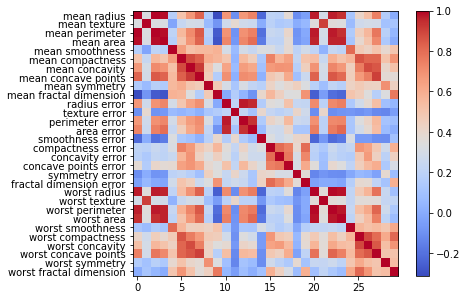

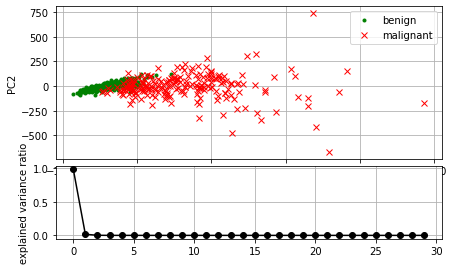

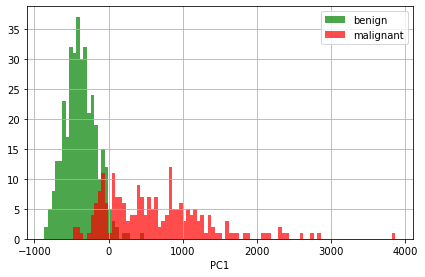

In [8]:
fig_size = plots.set_size(500)
fig = plt.figure(figsize=fig_size)
ax_1 = plt.subplot()
ax1=plt.imshow(features_cor,cmap='coolwarm')
# plt.xticks(np.arange(0,len(features_cor)),labels=data.feature_names,rotation=90)
plt.yticks(np.arange(0,len(features_cor)),labels=data.feature_names,rotation=0)
plt.colorbar(ax1,fraction=0.046,pad=0.04)
plt.tight_layout()

plt.figure(figsize=fig_size)
gs = gridspec.GridSpec(6,6)
ax_2 = plt.subplot(gs[:4,:])
ax_2.plot(features_decomp[y==1,0],features_decomp[y==1,1],'g.')
ax_2.plot(features_decomp[y==0,0],features_decomp[y==0,1],'rx')
ax_2.legend(['benign','malignant'])
ax_2.set_xlabel('PC1')
ax_2.set_ylabel('PC2')
ax_2.grid('on')
ax_3 = plt.subplot(gs[4:,:])
ax_3.plot(exp_var,'k-o')
# ax_3.set_xlabel('PC #')
ax_3.set_ylabel('explained variance ratio')
ax_3.grid('on')
plt.tight_layout()
plt.savefig('E:\Courses\Data_analysis_and_machine_learning\PCA_fig.pdf')

plt.figure(figsize=fig_size)
plt.hist(feat_benign,np.linspace(np.min(features_decomp[:,0]),np.max(features_decomp[:,0]),100),alpha=0.7,color='g')
plt.hist(feat_malign,np.linspace(np.min(features_decomp[:,0]),np.max(features_decomp[:,0]),100),alpha=0.7,color='r')
plt.xlabel('PC1')
plt.grid('on')
plt.legend(['benign','malignant'])
plt.savefig('E:\Courses\Data_analysis_and_machine_learning\PCA_hist_fig.pdf')

In [9]:
#%% Sklearn implementation vs Support Vector Machines vs 
#our implementation across learning rates and regularization values

#set pca_reduction to an integer corresponding to the number of principal features
#to do classification with. 0 leads to the use of the original features
pca_reduction = 0
if pca_reduction>0:        
    X = features_decomp[:,:pca_reduction]
lrs = np.logspace(-6,0,7)
penalties = np.logspace(-9,0,10)
success_rate_ours = np.zeros([len(penalties),len(lrs)])
success_rate_sklearn = np.zeros([len(penalties),len(lrs)])
success_rate_svm = np.zeros([len(penalties)])
count = 0

nfolds = 5
kf = KFold(n_splits=nfolds)
for p in range(len(penalties)):
    Classifier_SVC = SVC(C=1/penalties[p])
    sfold_svc = []
    for train_id, test_id in kf.split(X):
        X_train, X_test = X[train_id], X[test_id]
        y_train, y_test = y[train_id], y[test_id]
        fit_svc = Classifier_SVC.fit(X_train,y_train)
        sfold_svc.append(Classifier_SVC.score(X_test,y_test))
    success_rate_svm[p] = np.mean(sfold_svc)
    for l in range(len(lrs)):

        sfold_mean = []
        sfold_mean_sk = []
        for train_id, test_id in kf.split(y):
            X_train, X_test = X[train_id], X[test_id]
            y_train, y_test = y[train_id], y[test_id]
            Classifier_sklearn = SGDClassifier(loss='log',
                                               penalty='l2',
                                               alpha=penalties[p],
                                               learning_rate='constant',
                                               eta0=lrs[l],
                                               early_stopping=False,
                                               random_state=42,
                                               tol = 1e-3
                                              )

            Classifier_ours = LogisticRegression(penalty=penalties[p]/2,
                                                     batches=X_train.shape[0], 
                                                     learning_rate=Constant(eta0=lrs[l]),
                                                     early_stopping=False,
                                                     seed=42,
                                                     tol=1e-3 * X_train.shape[0],
                                                     verbose=False
                                                )

            
            Classifier_ours.fit(X_train,y_train)
            Classifier_sklearn.fit(X_train,y_train)

            classified = Classifier_ours.predict(X_test)
            sfold_mean.append(np.sum(classified==y_test)/len(y_test))
            sfold_mean_sk.append(Classifier_sklearn.score(X_test,y_test)) 
        success_rate_ours[p,l] = np.mean(sfold_mean)
        success_rate_sklearn[p,l] = np.mean(sfold_mean_sk)

success_rate_svm = np.expand_dims(success_rate_svm,1)    

E:\Code\CompSci\01_regression_resampling\src\stochastic_gradient_descent.py:159: RuntimeWarning: overflow encountered in subtract
  p -= (
E:\Code\CompSci\01_regression_resampling\src\linear_model.py:134: RuntimeWarning: overflow encountered in matmul
  y_y_prop = y - expit(p[0] + X @ p[1:])
E:\Code\CompSci\01_regression_resampling\src\linear_model.py:134: RuntimeWarning: invalid value encountered in matmul
  y_y_prop = y - expit(p[0] + X @ p[1:])
E:\Code\CompSci\01_regression_resampling\src\stochastic_gradient_descent.py:159: RuntimeWarning: overflow encountered in subtract
  p -= (
E:\Code\CompSci\01_regression_resampling\src\linear_model.py:134: RuntimeWarning: overflow encountered in matmul
  y_y_prop = y - expit(p[0] + X @ p[1:])
E:\Code\CompSci\01_regression_resampling\src\linear_model.py:134: RuntimeWarning: invalid value encountered in matmul
  y_y_prop = y - expit(p[0] + X @ p[1:])
E:\Code\CompSci\01_regression_resampling\src\stochastic_gradient_descent.py:159: RuntimeWarning:

In [10]:
success_rate_svm_reduced = np.zeros([len(penalties)])
pca_reduction = 1
X_red = features_decomp[:,:pca_reduction]
for p in range(len(penalties)):
    Classifier_SVC = SVC(C=1/penalties[p])
    sfold_svc = []
    for train_id, test_id in kf.split(X_red):
        X_train, X_test = X_red[train_id], X_red[test_id]
        y_train, y_test = y[train_id], y[test_id]
        fit_svc = Classifier_SVC.fit(X_train,y_train)
        sfold_svc.append(Classifier_SVC.score(X_test,y_test))
    success_rate_svm_reduced[p] = np.mean(sfold_svc)
success_rate_svm_reduced = np.expand_dims(success_rate_svm_reduced,1)

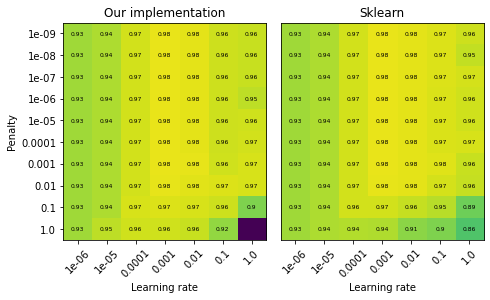

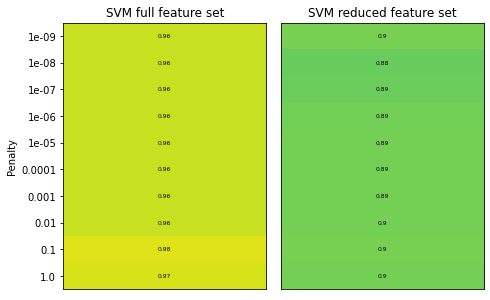

In [11]:
#%%Plot of the performance of different methods
#%%
plt.figure(figsize=fig_size)
plt.subplot(1,2,1)
plots.annotate_imshow(success_rate_ours,vmin=0.5,vmax=1)
plt.xticks(np.arange(0,len(lrs)),lrs,rotation=45)
plt.yticks(np.arange(0,len(penalties)),penalties)
plt.ylabel('Penalty')
plt.xlabel('Learning rate')
plt.title('Our implementation')
plt.subplot(1,2,2)
plots.annotate_imshow(success_rate_sklearn,vmin=0.5,vmax=1)
plt.xticks(np.arange(0,len(lrs)),lrs,rotation=45)
plt.yticks([])
plt.xlabel('Learning rate')
plt.title('Sklearn')
plt.tight_layout()

#
plt.figure(figsize=fig_size)
plt.subplot(1,2,1)
plots.annotate_imshow(success_rate_svm,vmin=0.5,vmax=1)
plt.yticks(np.arange(0,len(penalties)),penalties)
plt.ylabel('Penalty')
plt.xticks([])
plt.title('SVM full feature set')
plt.subplot(1,2,2)
plots.annotate_imshow(success_rate_svm_reduced,vmin=0.5,vmax=1)
plt.xticks([])
plt.yticks([])
plt.title('SVM reduced feature set')
plt.tight_layout()
